# Assignment 2: Deep learning on images

## Libraries, parameters

In [2]:
from pathlib import Path
import py360convert
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import cv2

2025-05-18 13:35:10.181537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 13:35:11.703414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 13:35:12.466615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747568113.067595    6588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747568113.260727    6588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747568115.669934    6588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
# Cropping parameters
CROP_WIDTH = 13271
CROP_HEIGHT = 6619
CROP_X = 0
CROP_Y = 16

ROOT_DIR = Path("images")
CROPPED_DIR = Path("cropped_images")
SLICED_DIR = Path("sliced_panoramas_split")
GRAD_CAM_DIR = Path("grad_cam")

# Image processing parameters
OUTPUT_SIZE = (512, 1024)  # High-res directional slices
ANGLES = [0, 90, 180, 270]
TRAIN_IMG_SIZE = (224, 224)  # For resizing during training

# Model parameters
BATCH_SIZE = 8
SEED = 42
EPOCHS = 20

In [ ]:
image_extensions = ('.jpg', '.jpeg', '.png')
country_counts = []

for country_dir in sorted(ROOT_DIR.iterdir()):
    if country_dir.is_dir():
        # Only count files with image extensions, ignore hidden/system files
        count = sum(
            1 for img in country_dir.iterdir()
            if img.suffix.lower() in image_extensions and not img.name.startswith('.')
        )
        country_counts.append({"Country": country_dir.name, "Image Count": count})

country_df = pd.DataFrame(country_counts).sort_values(by="Image Count", ascending=False)

fig = px.bar(
    country_df,
    x="Country",
    y="Image Count",
    color="Country",
    color_discrete_sequence=px.colors.qualitative.Pastel2
)

fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Number of Images",
    showlegend=False,
    template="plotly_white"
)

fig.show()



## Image preprocessing and train test split

In [ ]:
for img_path in ROOT_DIR.rglob("*.jpg"):
    with Image.open(img_path) as img:
        # Ensure the image is large enough before cropping
        if img.width >= CROP_WIDTH and img.height >= (CROP_Y + CROP_HEIGHT):
            cropped_img = img.crop((CROP_X, CROP_Y, CROP_X + CROP_WIDTH, CROP_Y + CROP_HEIGHT))

            # Get relative path inside "images/"
            relative_path = img_path.relative_to(ROOT_DIR)  
            save_path = CROPPED_DIR / relative_path
            save_path.parent.mkdir(parents=True, exist_ok=True)
            
            cropped_img.save(save_path)
            print(f"Cropped and saved: {save_path}")
        else:
            print(f"Skipping {img_path} (too small for cropping)")

In [ ]:
all_panos = list(CROPPED_DIR.rglob("*.jpg"))

labels = [pano.parent.name for pano in all_panos]
train_panos, test_panos = train_test_split(
    all_panos, test_size=0.2, stratify=labels, random_state=SEED
)

train_labels = [pano.parent.name for pano in train_panos]
train_panos, validation_panos = train_test_split(
    train_panos, test_size=0.25, stratify=train_labels, random_state=SEED
)

print(f"Train panoramas: {len(train_panos)}")
print(f"Validation panoramas:  {len(validation_panos)}")
print(f"Test panoramas:  {len(test_panos)}")

In [ ]:
def slice_and_save(pano_paths, split: str):
    for pano_path in pano_paths:
        try:
            img = tf.keras.utils.load_img(pano_path)
            arr = tf.keras.utils.img_to_array(img)

            country = pano_path.parent.name
            base_name = pano_path.stem

            output_dir = SLICED_DIR / split / country
            output_dir.mkdir(parents=True, exist_ok=True)

            for angle in ANGLES:
                output_path = output_dir / f"{base_name}_a{angle}.png"

                if not output_path.exists():
                    view = py360convert.e2p(
                        arr, fov_deg=90, u_deg=angle, v_deg=0, out_hw=OUTPUT_SIZE
                    )
                    tf.keras.utils.save_img(output_path, view)

        except Exception as e:
            print(f"Skipping {pano_path.name} due to error: {e}")

# Slice and save the panoramas
slice_and_save(train_panos, "train")
slice_and_save(validation_panos, "validation")
slice_and_save(test_panos, "test")

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    SLICED_DIR / "train",
    image_size=TRAIN_IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    SLICED_DIR / "validation",
    image_size=TRAIN_IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)
class_names = train_ds.class_names
num_classes = len(class_names)

train_ds = train_ds.shuffle(1000, seed=SEED).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


print("Classes:", class_names)
print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))

Found 6336 files belonging to 12 classes.
Found 2112 files belonging to 12 classes.
Classes: ['argentina', 'austria', 'canada', 'chile', 'france', 'iceland', 'italy', 'japan', 'new_zealand', 'norway', 'peru', 'switzerland']
Train batches: 792
Val batches: 264


## Class imbalance

In [12]:
# Extract and count labels
true_labels = tf.concat([y for _, y in train_ds], axis=0).numpy()
label_counts = Counter(true_labels)

# Create sorted DataFrame directly
dist_df = pd.DataFrame([
    {'Class': class_names[i], 'Count': count}
    for i, count in label_counts.items()
]).sort_values(by='Count', ascending=False).reset_index(drop=True)

dist_df


2025-05-18 13:39:28.447682: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Class,Count
0,switzerland,732
1,austria,644
2,japan,600
3,italy,600
4,canada,596
5,chile,592
6,norway,552
7,france,520
8,new_zealand,480
9,peru,380


In [ ]:
%matplotlib inline
# Get class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(true_labels),
    y=true_labels
)

# Create dictionary: {class_index: weight}
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Visualize class weights per class
weights_df = pd.DataFrame({
    'Class Index': list(class_weight_dict.keys()),
    'Class Name': [class_names[i] for i in class_weight_dict.keys()],
    'Weight': list(class_weight_dict.values())
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

fig = px.bar(
    weights_df,
    x="Class Name",
    y="Weight",
    color="Weight",
    text="Weight",
    hover_data=["Class Index"],
    color_continuous_scale="Mint"
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Class Weight"
)

fig.show()


weights_df


,Class Index,Class Name,Weight
0,5,iceland,1.859155
1,0,argentina,1.483146
2,10,peru,1.389474
3,8,new_zealand,1.100000
4,4,france,1.015385
5,9,norway,0.956522
6,3,chile,0.891892
7,2,canada,0.885906
8,7,japan,0.880000
9,6,italy,0.880000


## Model training

In [27]:

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze initially

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

metrics = ['accuracy']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

In [ ]:

# Callback to save the best model
checkpoint = ModelCheckpoint(
    'efficientnetb0_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
callbacks = [checkpoint, earlystopper]
 
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3552 - loss: 1.8035
Epoch 1: val_accuracy improved from -inf to 0.53693, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 147s 167ms/step - accuracy: 0.3553 - loss: 1.8032 - val_accuracy: 0.5369 - val_loss: 1.2794
Epoch 2/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5265 - loss: 1.2873
Epoch 2: val_accuracy improved from 0.53693 to 0.58239, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 121s 149ms/step - accuracy: 0.5265 - loss: 1.2873 - val_accuracy: 0.5824 - val_loss: 1.1879
Epoch 3/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5694 - loss: 1.1713
Epoch 3: val_accuracy did not improve from 0.58239
792/792 ━━━━━━━━━━━━━━━━━━━━ 122s 149ms/step - accuracy: 0.5694 - loss: 1.1713 - val_accuracy: 0.5748 - val_loss: 1.1819
Epoch 4/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5852 - loss: 1.0870
Epoch 4: val_accuracy improved from 0.5

In [29]:
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=metrics)


fine_tune_epochs = 20
history_finetune = model.fit(train_ds,
                             validation_data=val_ds,
                             epochs=fine_tune_epochs,
                             callbacks=callbacks, class_weight=class_weight_dict)

Epoch 1/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6477 - loss: 0.9100
Epoch 1: val_accuracy improved from 0.61506 to 0.63258, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 342s 395ms/step - accuracy: 0.6477 - loss: 0.9100 - val_accuracy: 0.6326 - val_loss: 1.0453
Epoch 2/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7046 - loss: 0.8005
Epoch 2: val_accuracy did not improve from 0.63258
792/792 ━━━━━━━━━━━━━━━━━━━━ 305s 379ms/step - accuracy: 0.7046 - loss: 0.8005 - val_accuracy: 0.6321 - val_loss: 1.0450
Epoch 3/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7054 - loss: 0.7498
Epoch 3: val_accuracy improved from 0.63258 to 0.64157, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 328s 410ms/step - accuracy: 0.7054 - loss: 0.7498 - val_accuracy: 0.6416 - val_loss: 1.0012
Epoch 4/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7223 - loss: 0.7148
Epoch 4: val_accuracy improved from 

2025-05-18 21:40:15.793990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 727 of 1000
2025-05-18 21:40:16.423716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7523 - loss: 0.6240
Epoch 7: val_accuracy did not improve from 0.65862
792/792 ━━━━━━━━━━━━━━━━━━━━ 347s 424ms/step - accuracy: 0.7523 - loss: 0.6240 - val_accuracy: 0.6548 - val_loss: 0.9857
Epoch 8/20


2025-05-18 21:46:02.822353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 707 of 1000
2025-05-18 21:46:04.336151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7644 - loss: 0.5894
Epoch 8: val_accuracy improved from 0.65862 to 0.66856, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 356s 434ms/step - accuracy: 0.7644 - loss: 0.5894 - val_accuracy: 0.6686 - val_loss: 0.9402
Epoch 9/20


2025-05-18 21:51:58.505323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 595 of 1000
2025-05-18 21:52:01.180246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7655 - loss: 0.5822
Epoch 9: val_accuracy improved from 0.66856 to 0.67093, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 350s 425ms/step - accuracy: 0.7655 - loss: 0.5822 - val_accuracy: 0.6709 - val_loss: 0.9729
Epoch 10/20


2025-05-18 21:57:47.946193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 625 of 1000
2025-05-18 21:57:50.980425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7792 - loss: 0.5598
Epoch 10: val_accuracy did not improve from 0.67093
792/792 ━━━━━━━━━━━━━━━━━━━━ 352s 428ms/step - accuracy: 0.7792 - loss: 0.5598 - val_accuracy: 0.6667 - val_loss: 0.9608
Epoch 11/20


2025-05-18 22:03:40.517490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 643 of 1000
2025-05-18 22:03:43.572779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7784 - loss: 0.5488
Epoch 11: val_accuracy improved from 0.67093 to 0.67756, saving model to efficientnetb0_model.keras
792/792 ━━━━━━━━━━━━━━━━━━━━ 355s 431ms/step - accuracy: 0.7784 - loss: 0.5488 - val_accuracy: 0.6776 - val_loss: 0.9374
Epoch 12/20


2025-05-18 22:09:35.262927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 559 of 1000
2025-05-18 22:09:39.928843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7953 - loss: 0.5077
Epoch 12: val_accuracy did not improve from 0.67756
792/792 ━━━━━━━━━━━━━━━━━━━━ 353s 427ms/step - accuracy: 0.7953 - loss: 0.5077 - val_accuracy: 0.6761 - val_loss: 0.9769
Epoch 13/20


2025-05-18 22:15:28.608200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 572 of 1000
2025-05-18 22:15:33.358010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8054 - loss: 0.4808
Epoch 13: val_accuracy did not improve from 0.67756
792/792 ━━━━━━━━━━━━━━━━━━━━ 353s 427ms/step - accuracy: 0.8054 - loss: 0.4808 - val_accuracy: 0.6742 - val_loss: 1.0051
Epoch 14/20


2025-05-18 22:21:21.596544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 603 of 1000
2025-05-18 22:21:25.668747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8024 - loss: 0.4740
Epoch 14: val_accuracy did not improve from 0.67756
792/792 ━━━━━━━━━━━━━━━━━━━━ 349s 423ms/step - accuracy: 0.8024 - loss: 0.4739 - val_accuracy: 0.6747 - val_loss: 1.0174


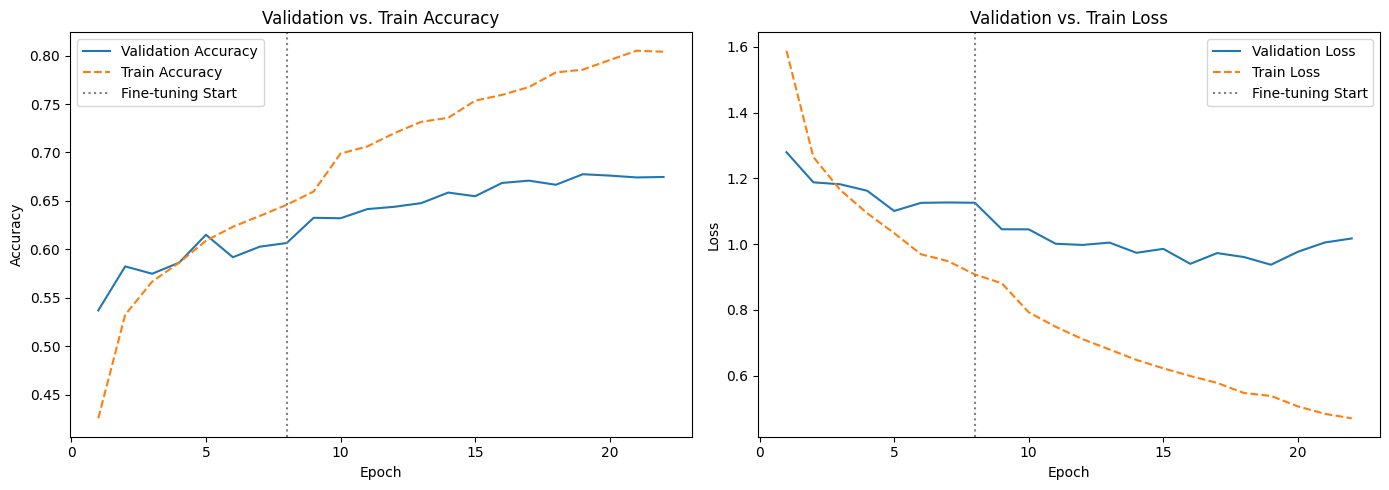

In [30]:
def plot_combined_history(history, history_finetune):
    # Combine the accuracy and loss
    acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history.history['val_loss'] + history_finetune.history['val_loss']
    
    train_acc = history.history['accuracy'] + history_finetune.history['accuracy']
    train_loss = history.history['loss'] + history_finetune.history['loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Validation Accuracy')
    plt.plot(epochs, train_acc, label='Train Accuracy', linestyle='--')
    plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle=':', label='Fine-tuning Start')
    plt.title('Validation vs. Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Validation Loss')
    plt.plot(epochs, train_loss, label='Train Loss', linestyle='--')
    plt.axvline(x=len(history.history['loss']), color='gray', linestyle=':', label='Fine-tuning Start')
    plt.title('Validation vs. Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_combined_history(history, history_finetune)


## Test dataset

In [31]:
test_df = tf.keras.utils.image_dataset_from_directory(
    SLICED_DIR / "test",
    image_size=TRAIN_IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

Found 2112 files belonging to 12 classes.


In [32]:
# Get the true labels
true_labels = tf.concat([y for _, y in test_df], axis=0)
# Generate predictions
predictions = model.predict(test_df)
# Get the predicted labels
predicted_labels = tf.argmax(predictions, axis=1)
model_accuracy = np.mean(predicted_labels.numpy() == true_labels.numpy())


# Create confusion matrix
confusion_matrix = tf.math.confusion_matrix(
    labels=true_labels,
    predictions=predicted_labels,
    num_classes=len(test_df.class_names)
)

# Normalize confusion matrix to percentage
cm_percentage = confusion_matrix / tf.math.reduce_sum(confusion_matrix, axis=1, keepdims=True) * 100
# Create a dataframe for the heatmap
heatmap_df = pd.DataFrame(cm_percentage, columns=test_df.class_names, index=test_df.class_names)


fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        z=heatmap_df.values,
        x=heatmap_df.columns,
        y=heatmap_df.index,
        coloraxis='coloraxis',
        zmax=100,
        zmin=0
    )
)
fig.update_xaxes(title_text='Predicted')
fig.update_yaxes(title_text='True')
fig.update_layout(coloraxis=dict(colorscale='Blues'), title_text='{} : {:.2f}%'.format('Efficientnet', model_accuracy * 100))
fig.show()


264/264 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step


In [33]:
# Mistake summary
mistake_summary = {}
cm_np = confusion_matrix.numpy()

for i, true_class in enumerate(class_names):
    row =  cm_np[i].copy()
    row[i] = 0  # ignore correct predictions
    if row.sum() == 0:
        continue
    most_confused_idx = np.argmax(row)
    mistake_summary[true_class] = {
        "Mistaken As": class_names[most_confused_idx],
        "Mistake Count": row[most_confused_idx]
    }

mistake_df = pd.DataFrame([
    {"True Label": k, "Most Often Mistaken As": v["Mistaken As"], "Mistake Count": v["Mistake Count"]}
    for k, v in mistake_summary.items()
]).sort_values(by="Mistake Count", ascending=False).reset_index(drop=True)
mistake_df

,True Label,Most Often Mistaken As,Mistake Count
0,austria,italy,47
1,switzerland,japan,47
2,italy,austria,37
3,france,japan,28
4,argentina,chile,17
5,peru,chile,14
6,chile,argentina,10
7,norway,japan,7
8,canada,italy,6
9,japan,france,6


In [34]:
# Get full report
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=3)
print(report)

              precision    recall  f1-score   support

   argentina      0.745     0.658     0.699       120
     austria      0.569     0.458     0.508       216
      canada      0.759     0.918     0.831       196
       chile      0.819     0.860     0.839       200
      france      0.487     0.326     0.390       172
     iceland      0.682     0.815     0.743        92
       italy      0.392     0.355     0.373       200
       japan      0.616     0.890     0.728       200
 new_zealand      0.994     0.981     0.987       160
      norway      0.859     0.924     0.890       184
        peru      0.800     0.625     0.702       128
 switzerland      0.568     0.545     0.556       244

    accuracy                          0.687      2112
   macro avg      0.691     0.696     0.687      2112
weighted avg      0.678     0.687     0.676      2112



In [ ]:
GRAD_CAM_DIR.mkdir(parents=True, exist_ok=True)

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
], name="data_aug")

# Functional rebuild
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
conv_output = x
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

functional_model = tf.keras.models.Model(inputs, outputs)
functional_model.set_weights(model.get_weights())

# Grad-CAM model
grad_model = tf.keras.models.Model(
    inputs=functional_model.input,
    outputs=[functional_model.output, conv_output]
)

def compute_gradcam(image, model, class_index):
    with tf.GradientTape() as tape:
        preds, conv_outputs = model(image)
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_gradcam_image(image_tensor, label, pred_class, class_names, model):
    heatmap = compute_gradcam(image_tensor, model, pred_class)

    # Convert image
    img_array = image_tensor[0].numpy()
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    img_rgb = img_array

    # Resize heatmap and overlay
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_array, 0.5, heatmap_colored, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_rgb)
    ax[0].set_title(f"Original: {class_names[label]}")
    ax[0].axis("off")

    ax[1].imshow(heatmap_resized, cmap="jet")
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay_rgb)
    ax[2].set_title(f"Overlay\nPredicted: {class_names[pred_class]}")
    ax[2].axis("off")

    plt.tight_layout()

    # Save as grad_cam/truelabel_predictedlabel.png
    filename = f"{class_names[label]}_{class_names[pred_class]}.png"
    label_folder = GRAD_CAM_DIR / class_names[label]
    label_folder.mkdir(parents=True, exist_ok=True)
    plt.savefig(label_folder / filename)
    plt.close()


# Unbatch and process one image at a time
for image, label in test_df.unbatch():
    label_int = label.numpy()

    image_batch = tf.expand_dims(tf.cast(image, tf.float32), axis=0)
    pred = functional_model.predict(image_batch, verbose=0)
    pred_class = tf.argmax(pred[0]).numpy()

    save_gradcam_image(
        image_batch,
        label_int,
        pred_class,
        test_df.class_names,
        grad_model
    )